# Import needed modules

In [ ]:
model_name_version = 'InceptionResNetV2'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

#### **Function to create data frame**

In [ ]:
# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Function that create dataframe for train, validation, and test data
def create_df(data_dir):

    # train dataframe
    files1, classes1 = define_paths(data_dir[0])
    train_df = define_df(files1, classes1)

    # test dataframe
    files, classes = define_paths(data_dir[1])
    test_df = define_df(files, classes)

    return train_df, test_df

#### **Function to display data sample**

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Function to plot value counts for a column in a dataframe**

In [ ]:
def plot_label_count(df, plot_title):
    '''
    This function take df and plot labels value counts
    '''

    # Define needed variables
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(labels, values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, initial_lr):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        self.initial_lr = initial_lr

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        # msg = 'Do you want model asks you to halt the training [y/n] ?'
        # print(msg)
        # ans = input('')
        # if ans in ['Y', 'y']:
        #     self.ask_permission = 1
        # elif ans in ['N', 'n']:
        self.ask_permission = 0

        # reset/initialize LR
        tf.keras.backend.set_value(self.model.optimizer.lr, self.initial_lr) # set the learning rate in the optimizer

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
                if pimprov > 0.5:
                    self.stop_count = 0 # reset 
                else:
                    self.stop_count = self.stop_count + 1 # increment stop counter since v_loss change is insignificant
                    

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

In [ ]:
data_dir = ['/content/drive/MyDrive/C-NMC_Leukemia/training_data','/content/drive/MyDrive/C-NMC_Leukemia/validation_data']

try:
    # Get splitted data
    train_df, test_df = create_df(data_dir)

except:
    print('Invalid Input')

#### Callback parameters

In [ ]:
initial_lr = 0.0012   # initial learning rate
batch_size = 40   # set batch size for training
epochs = 30   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 5   # number of epochs to wait before stopping training if monitored value does not improve
                    # or if monitored value improves but less tham 0.5% if val_loss is monitored
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training


#### Define batch size, and steps, and image data Generator

In [ ]:
# Recommended : use custom function for test data batch size, else we can use normal batch size.
batch_size = 40
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# define model parameters
img_size = (224, 224)
channels = 3 # either BGR or Grayscale
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)

def scalar(img):
    return img

# train gen with data augnmentation, valid and test gen does not have augmentation
tr_gen = ImageDataGenerator(
    preprocessing_function= scalar,
    rotation_range=50,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

#Only test gen stays the same. Train and valid gen changes per fold
test_gen = val_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)


Found 1867 validated image filenames belonging to 2 classes.


###**Initialize Prediction array, Create and Compile Model and Save In:itial Weights**

In [ ]:
#Initialize prediction and val_accuracies array
predictions = []
val_accuracies = []
val_losses = []
train_y = train_df.labels
train_x = train_df.drop(['labels'],axis=1)
folds = 5

# create and compile pre-trained model
base_model = tf.keras.applications.InceptionResNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
  base_model,
  BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
  Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
  Dropout(rate= 0.45, seed= 123),
  Dense(2, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.0012), loss= 'categorical_crossentropy', metrics= ['accuracy'])
print('Model successfully compiled!')
model.save_weights(f'/content/drive/MyDrive/Models2/ALL-initial-{model_name_version}-weights.h5')
print('Model weights successfully saved!')
print('')

model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model successfully compiled!
Model weights successfully saved!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 51

# **K-Fold Cross Validation**

1.   Get Generators
2.   Create Model Structure
3.   Activate Callbacks
4.   Train Model
5.   Display Model Performance
6.   Get Predictions
7.   Plot Confusion Matrix and Classification Report
8.   Append the Prediction Probabilities in the Validation Fold

*******************************************
Fold # 1 / 5
*******************************************

Found 8536 validated image filenames belonging to 2 classes.
Found 2135 validated image filenames belonging to 2 classes.



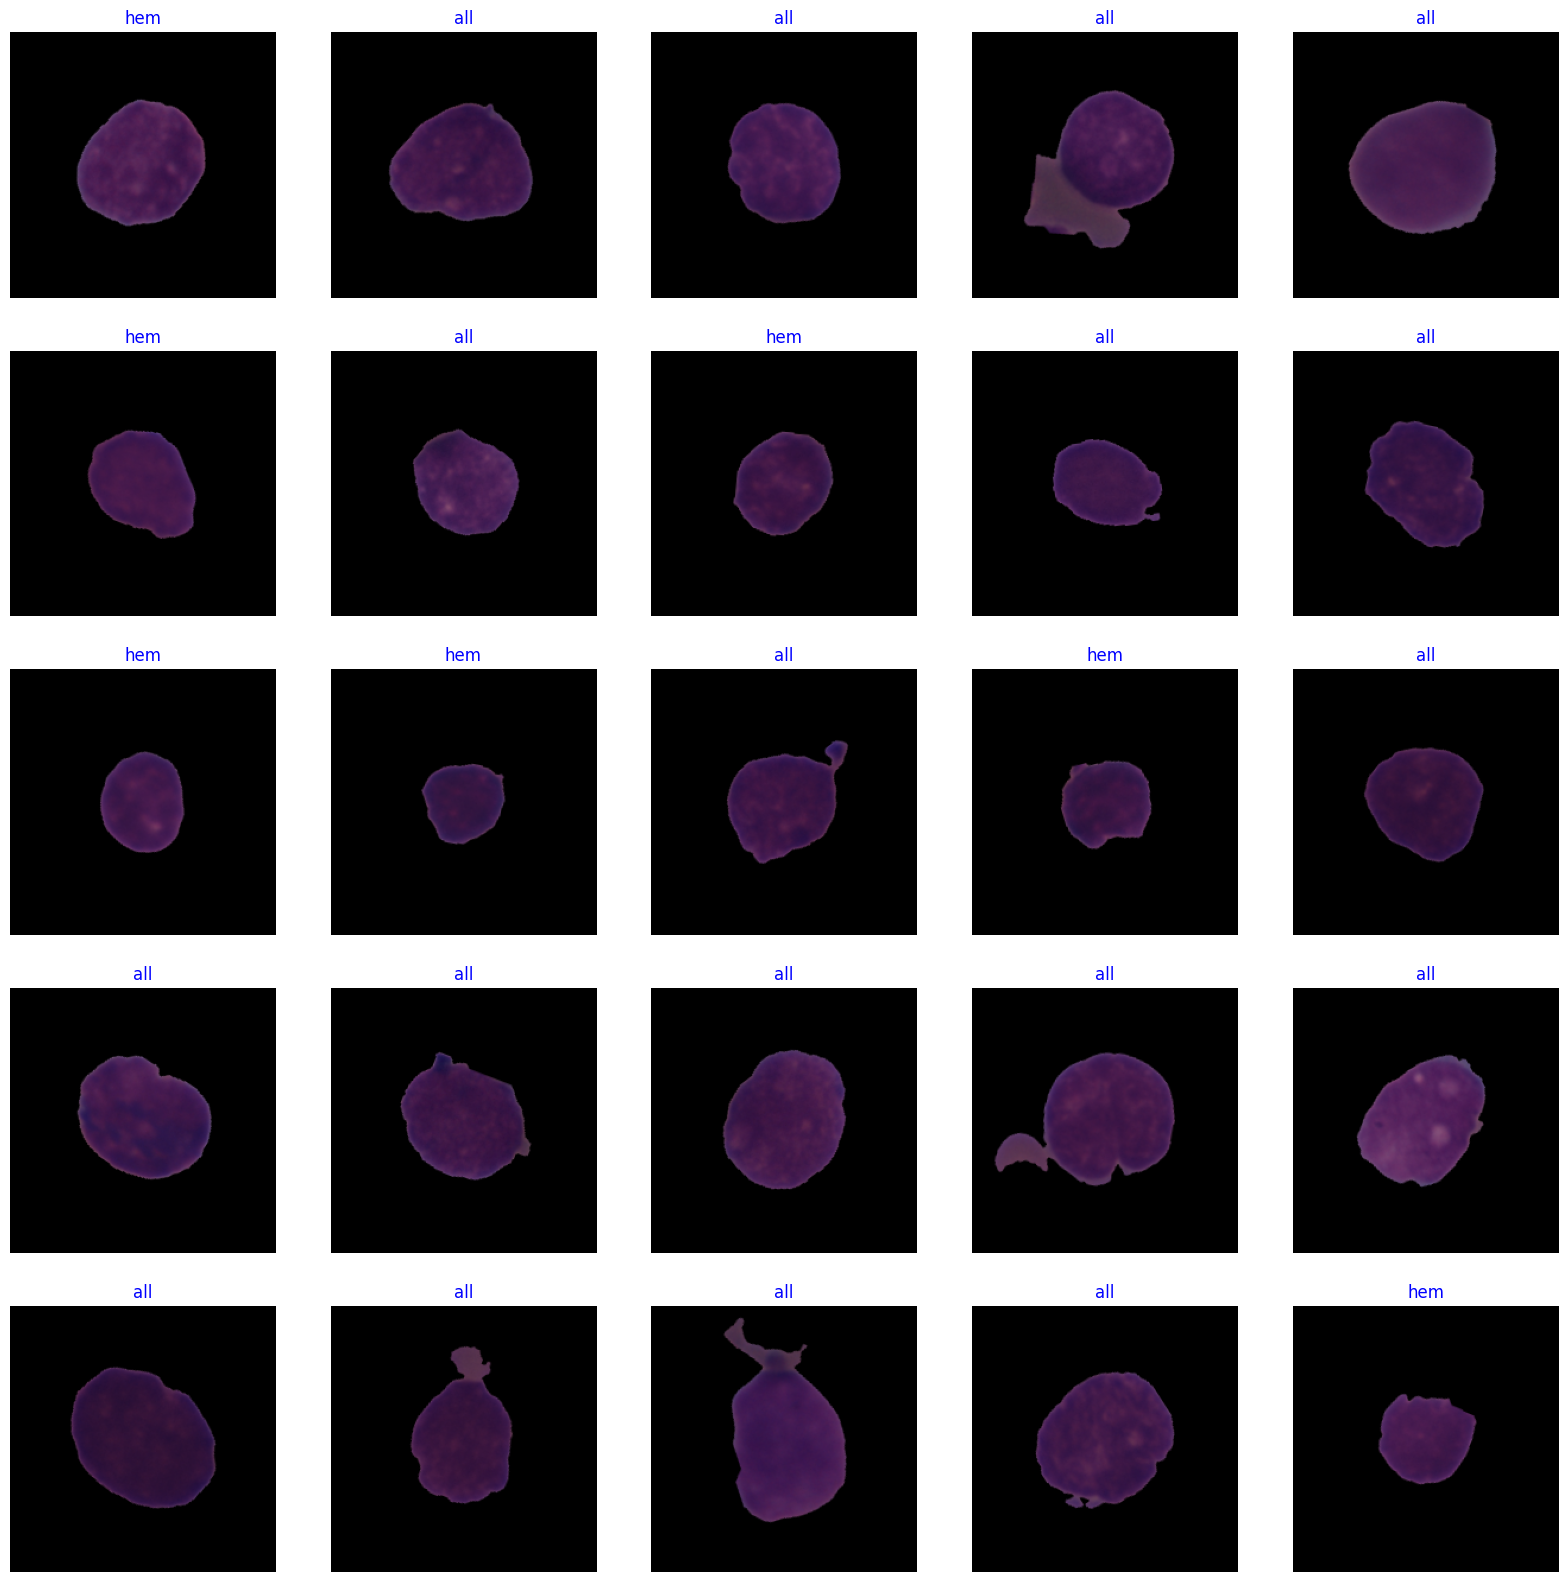


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/30
214/214 [==============================] - 2338s 11s/step - loss: 5.1488 - accuracy: 0.8271 - val_loss: 4.1842 - val_accuracy: 0.8253
Epoch 2/30
214/214 [==============================] - 157s 731ms/step - loss: 2.6904 - accuracy: 0.8743 - val_loss: 2.1728 - val_accuracy: 0.8548
Epoch 3/30
214/214 [==============================] - 158s 737ms/step - loss: 1.6360 - accuracy: 0.8920 - val_loss: 3.9704 - val_accuracy: 0.8323
Epoch 4/30
214/214 [==============================] - 156s 728ms/step - loss: 1.0481 - accuracy: 0.9009 - val_loss: 4.7736 - val_accuracy: 0.8478
Epoch 5/30
214/214 [==============================] - 156s 729ms/step - loss: 0.7465 - accuracy: 0.9214 - val_loss: 1.4492 - val_accuracy: 0.6234
Epoch 6/30
214/214 [==============================] - 156s 729ms/step - loss: 0.5999 - accuracy: 0.9274 - val_loss: 1.1150 - val_accuracy: 0.9073
Epoch 7/30
214/214 [============

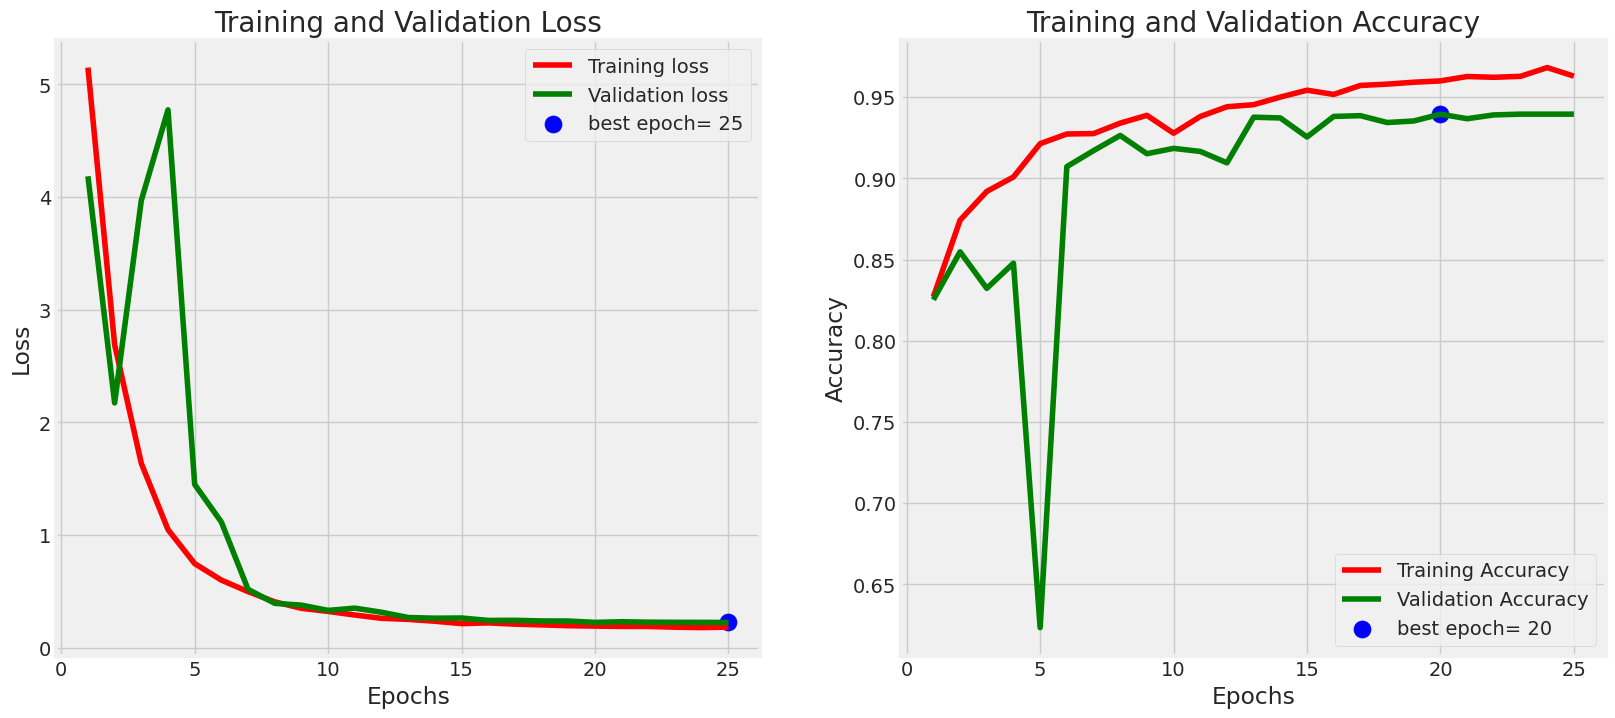


35/35 [==============================] - 7s 209ms/step - loss: 0.2281 - accuracy: 0.9364
Train Loss:  0.16443292796611786
Train Accuracy:  0.9681701064109802
--------------------
Validation Loss:  0.22811178863048553
Validation Accuracy:  0.9364285469055176
--------------------

Predictions:
[1 1 1 ... 1 1 1]

Confusion Matrix, Without Normalization
[[1401   56]
 [  73  605]]

              precision    recall  f1-score   support

         all       0.95      0.96      0.96      1457
         hem       0.92      0.89      0.90       678

    accuracy                           0.94      2135
   macro avg       0.93      0.93      0.93      2135
weighted avg       0.94      0.94      0.94      2135

*******************************************
Fold # 2 / 5
*******************************************

Found 8537 validated image filenames belonging to 2 classes.
Found 2134 validated image filenames belonging to 2 classes.


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Mo

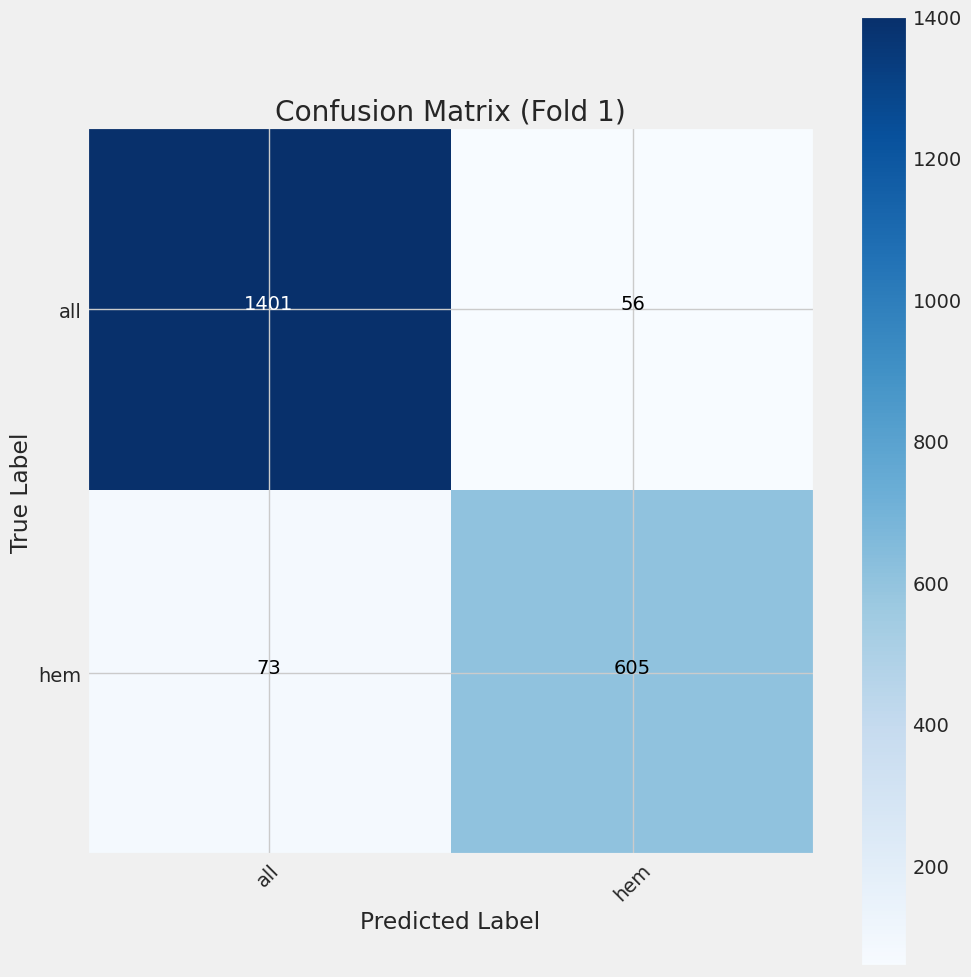

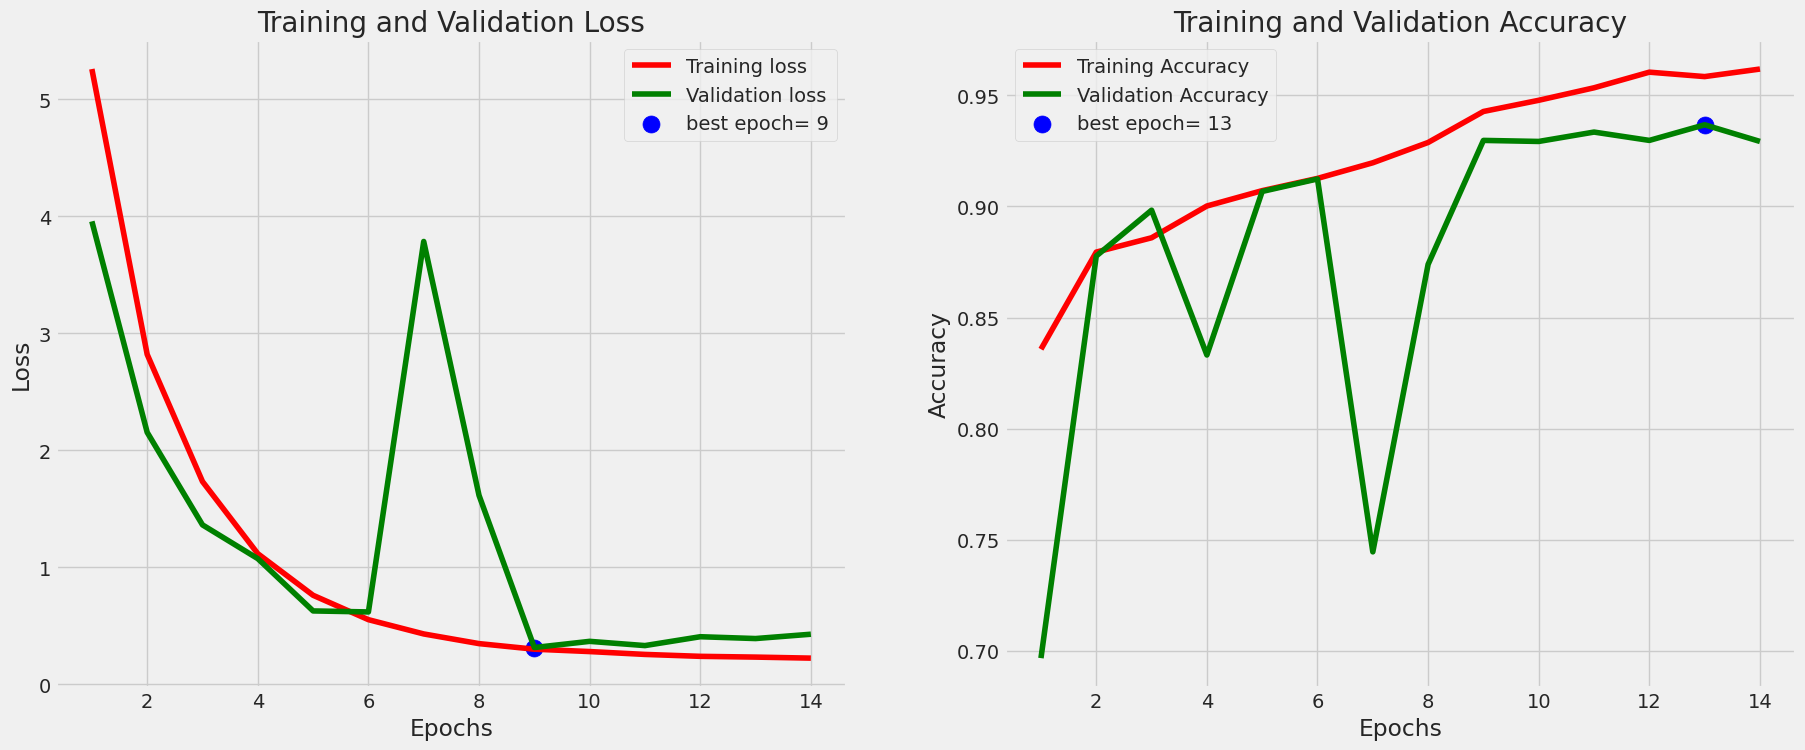


 214/8537 [..............................] - ETA: 1:07:42 - loss: 0.2505 - accuracy: 0.9606

54/97 [===============>..............] - ETA: 8s - loss: 0.3156 - accuracy: 0.9297

97/97 [==============================] - 11s 114ms/step - loss: 0.3156 - accuracy: 0.9297
Train Loss:  0.2505030035972595
Train Accuracy:  0.9606419205665588
--------------------
Validation Loss:  0.31558388471603394
Validation Accuracy:  0.9297094941139221
--------------------

Predictions:
[1 1 1 ... 1 1 1]

Confusion Matrix, Without Normalization
[[1384   72]
 [  78  600]]

              precision    recall  f1-score   support

         all       0.95      0.95      0.95      1456
         hem       0.89      0.88      0.89       678

    accuracy                           0.93      2134
   macro avg       0.92      0.92      0.92      2134
weighted avg       0.93      0.93      0.93      2134

*******************************************
Fold # 3 / 5
*******************************************

Found 8537 validated image filenames belonging to 2 classes.
Found 2134 validated image filenames belonging to 2 classes.


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Mon

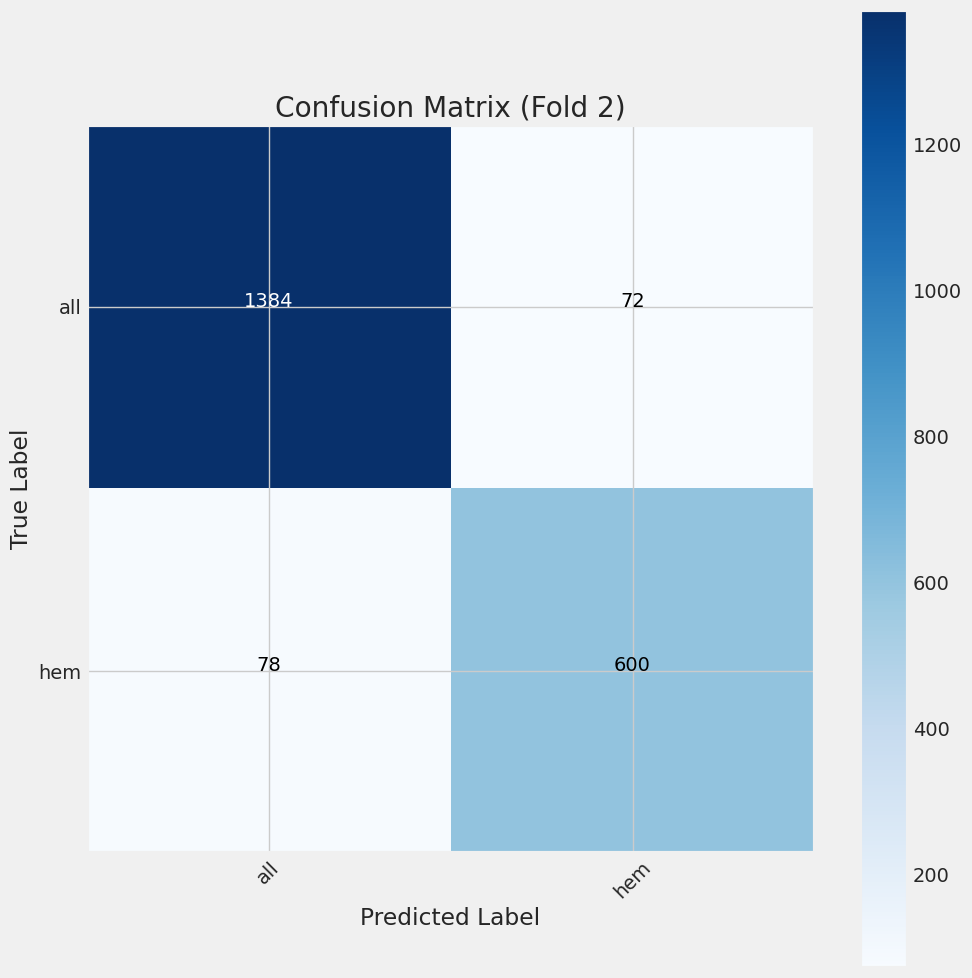

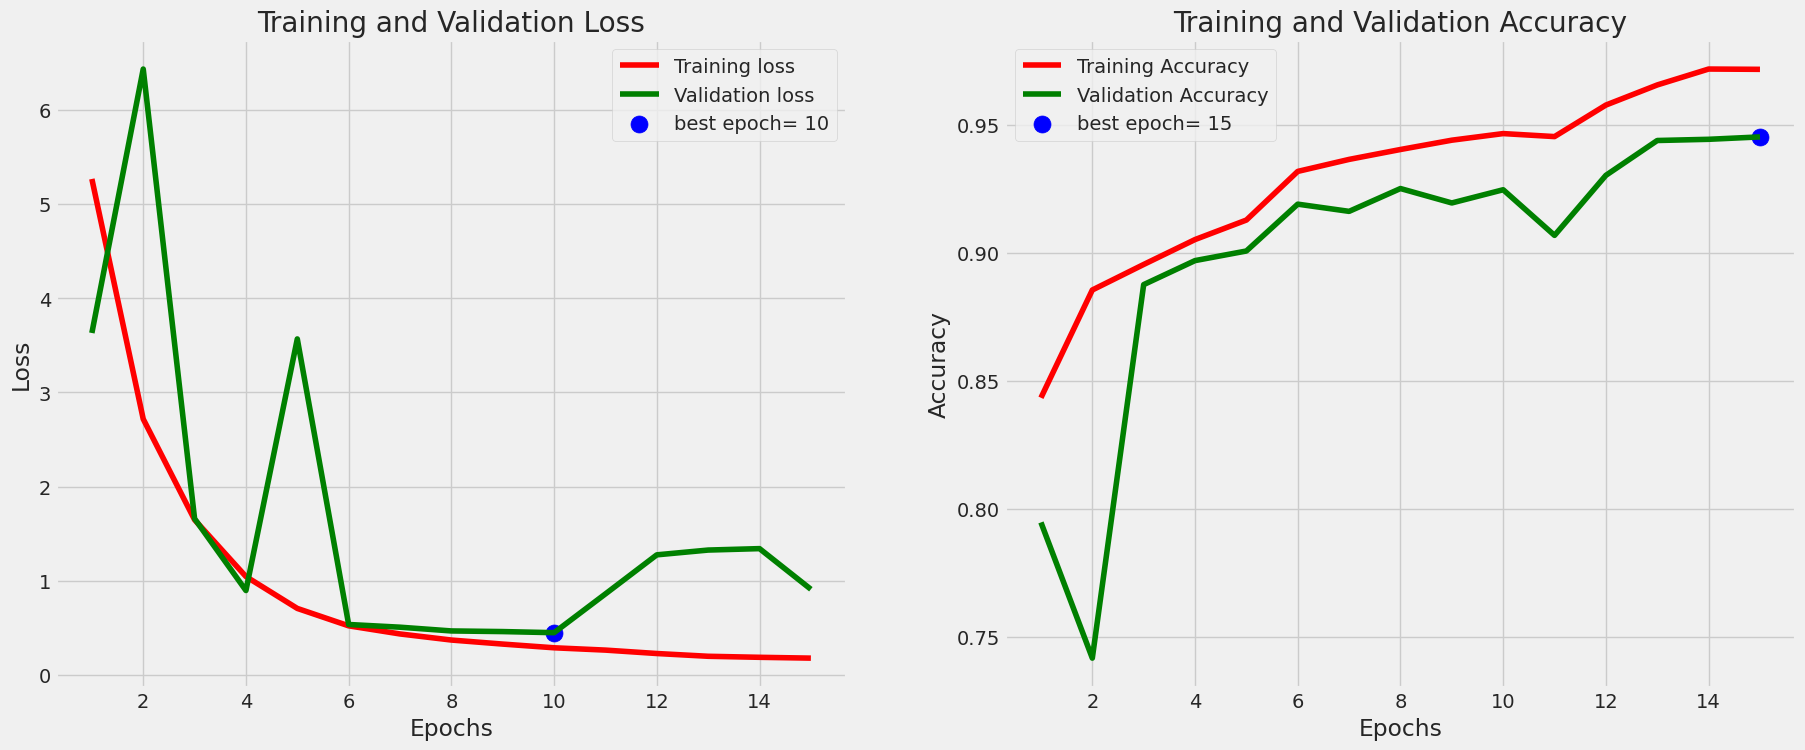


 214/8537 [..............................] - ETA: 1:06:51 - loss: 0.3060 - accuracy: 0.9549

54/97 [===============>..............] - ETA: 8s - loss: 0.4481 - accuracy: 0.9246

97/97 [==============================] - 11s 114ms/step - loss: 0.4481 - accuracy: 0.9246
Train Loss:  0.3059717118740082
Train Accuracy:  0.954902172088623
--------------------
Validation Loss:  0.4481240212917328
Validation Accuracy:  0.9245548248291016
--------------------

Predictions:
[1 1 1 ... 1 1 0]

Confusion Matrix, Without Normalization
[[1441   15]
 [ 146  532]]

              precision    recall  f1-score   support

         all       0.91      0.99      0.95      1456
         hem       0.97      0.78      0.87       678

    accuracy                           0.92      2134
   macro avg       0.94      0.89      0.91      2134
weighted avg       0.93      0.92      0.92      2134

*******************************************
Fold # 4 / 5
*******************************************

Found 8537 validated image filenames belonging to 2 classes.
Found 2134 validated image filenames belonging to 2 classes.


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monit

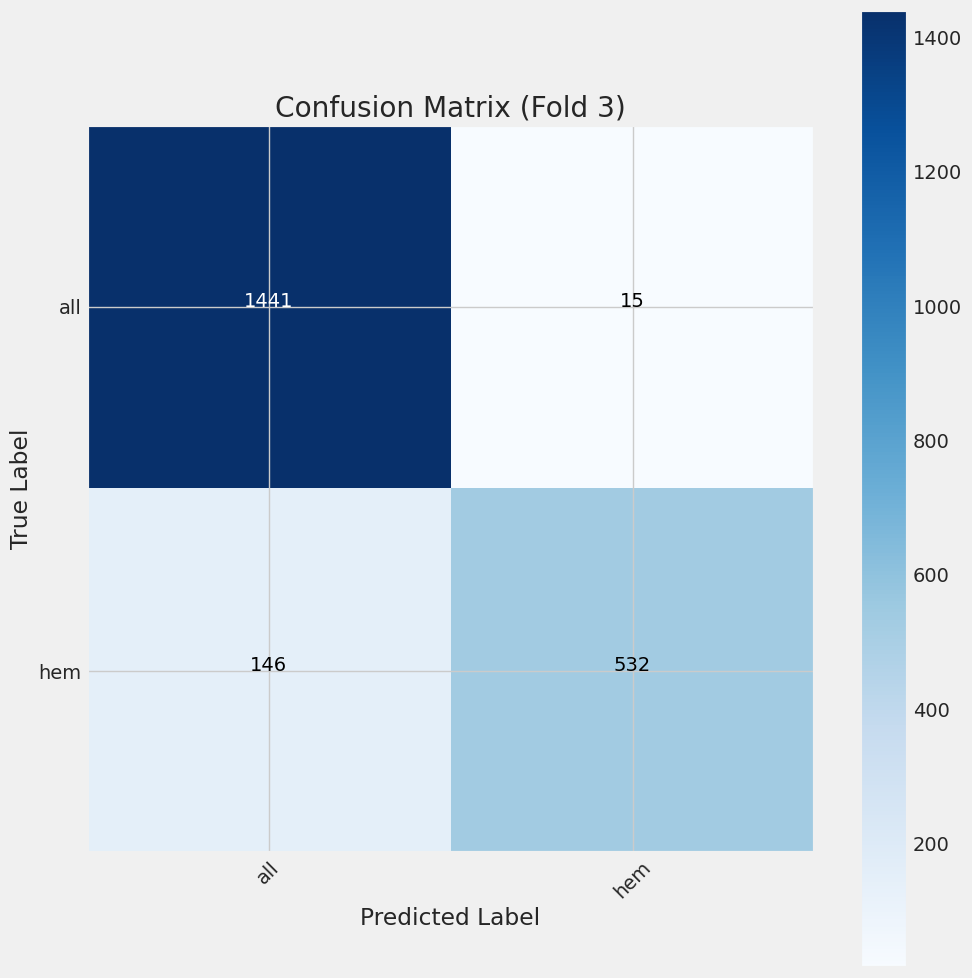

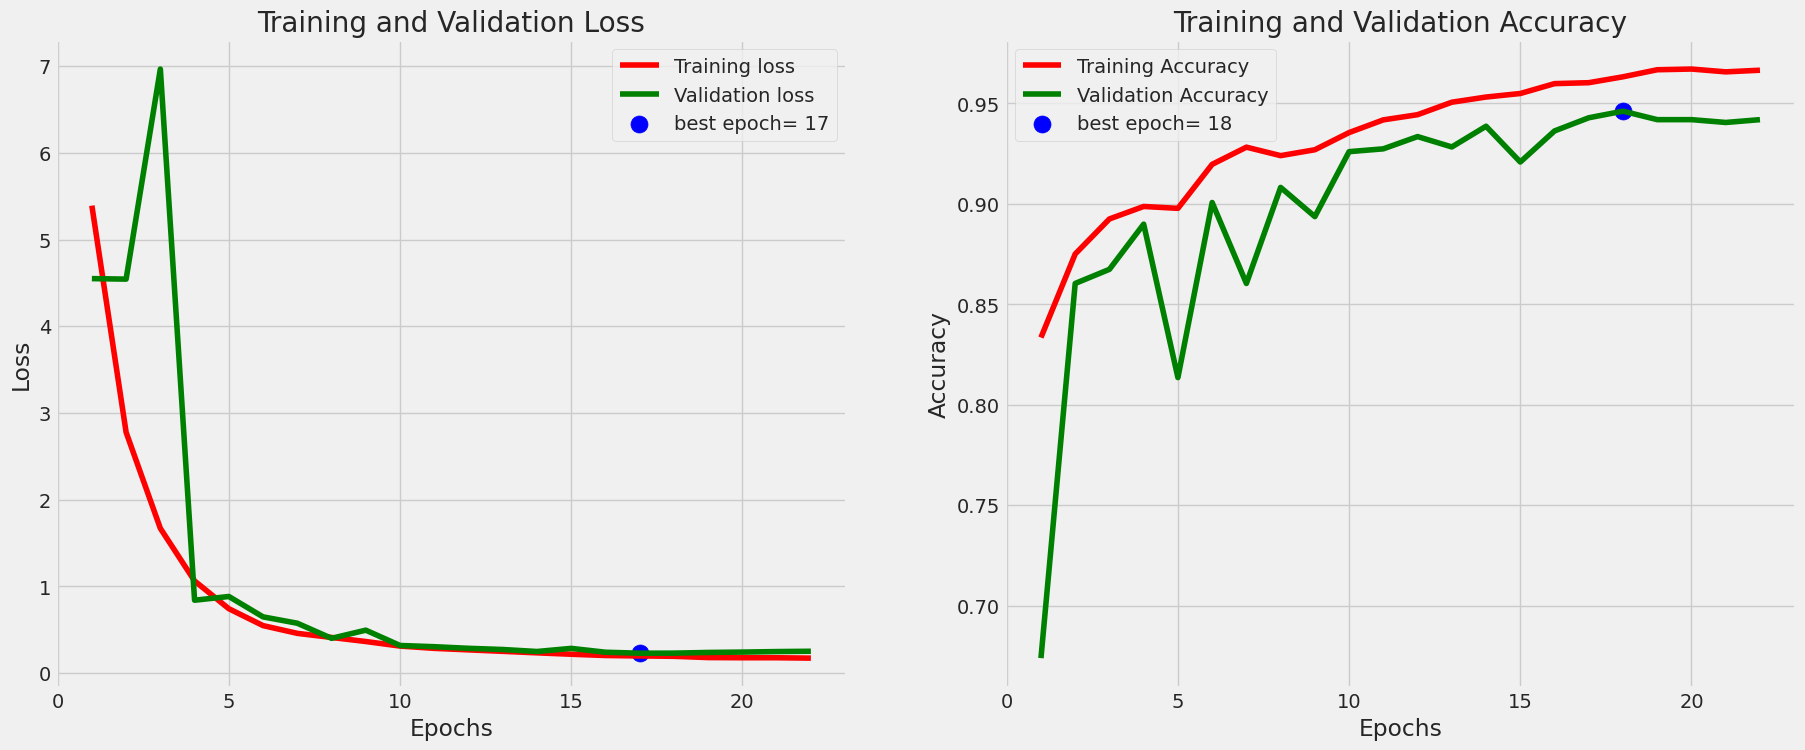


 214/8537 [..............................] - ETA: 1:08:42 - loss: 0.1699 - accuracy: 0.9721

54/97 [===============>..............] - ETA: 8s - loss: 0.2290 - accuracy: 0.9428

97/97 [==============================] - 11s 115ms/step - loss: 0.2290 - accuracy: 0.9428
Train Loss:  0.1699363738298416
Train Accuracy:  0.9721213579177856
--------------------
Validation Loss:  0.22901108860969543
Validation Accuracy:  0.9428303837776184
--------------------

Predictions:
[1 1 1 ... 1 1 1]

Confusion Matrix, Without Normalization
[[1409   47]
 [  75  603]]

              precision    recall  f1-score   support

         all       0.95      0.97      0.96      1456
         hem       0.93      0.89      0.91       678

    accuracy                           0.94      2134
   macro avg       0.94      0.93      0.93      2134
weighted avg       0.94      0.94      0.94      2134

*******************************************
Fold # 5 / 5
*******************************************

Found 8537 validated image filenames belonging to 2 classes.
Found 2134 validated image filenames belonging to 2 classes.


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Mon

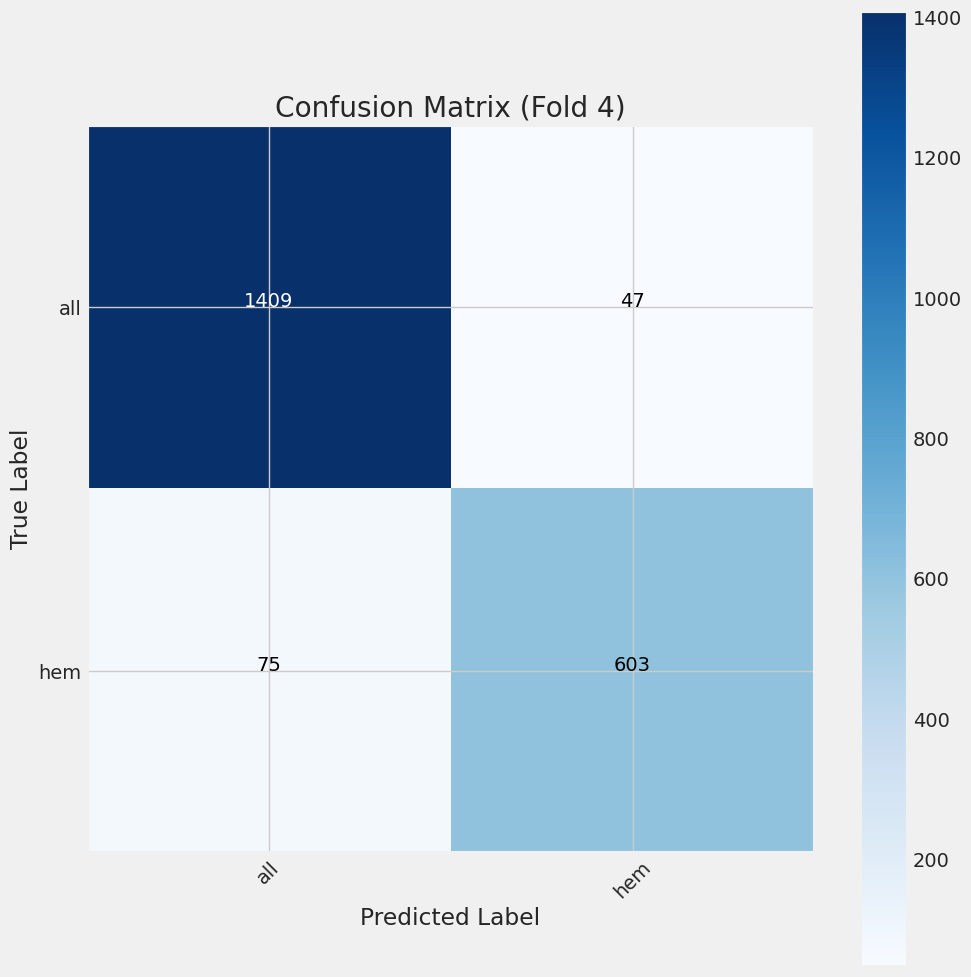

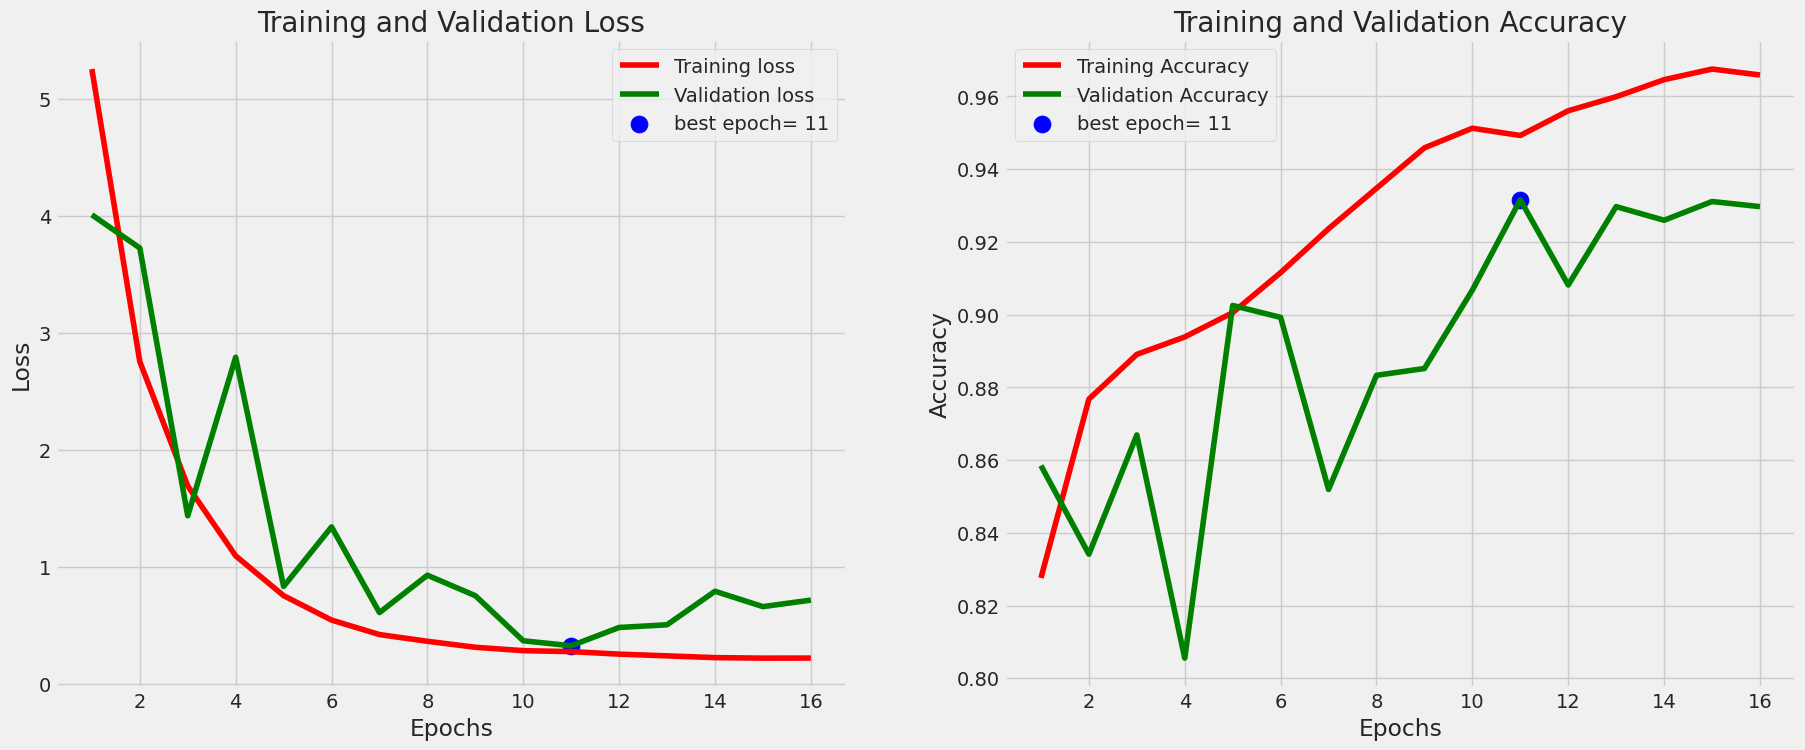


 214/8537 [..............................] - ETA: 1:09:41 - loss: 0.2290 - accuracy: 0.9647

54/97 [===============>..............] - ETA: 8s - loss: 0.3232 - accuracy: 0.9316

97/97 [==============================] - 11s 115ms/step - loss: 0.3232 - accuracy: 0.9316
Train Loss:  0.22903965413570404
Train Accuracy:  0.9647417068481445
--------------------
Validation Loss:  0.32315877079963684
Validation Accuracy:  0.9315838813781738
--------------------

Predictions:
[1 1 1 ... 1 1 1]

Confusion Matrix, Without Normalization
[[1408   49]
 [  97  580]]

              precision    recall  f1-score   support

         all       0.94      0.97      0.95      1457
         hem       0.92      0.86      0.89       677

    accuracy                           0.93      2134
   macro avg       0.93      0.91      0.92      2134
weighted avg       0.93      0.93      0.93      2134



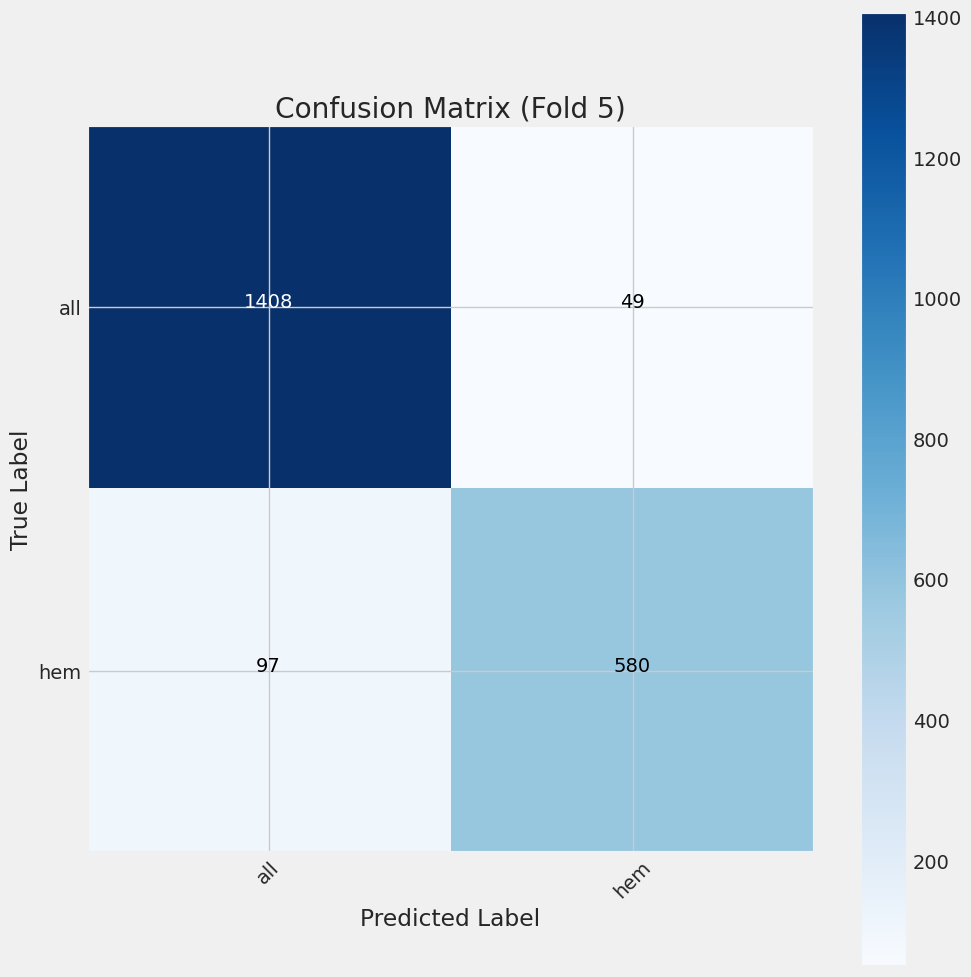

In [13]:
#Perform K Fold Cross Validation
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in list(skf.split(train_x,train_y)):

  print('*******************************************')
  print('Fold #',fold,'/',folds)
  print('*******************************************')
  print('')

  # Identify offsets
  x_train_df = train_df.iloc[train_index]
  x_valid_df = train_df.iloc[val_index]

  # Get Generators
  train_gen = tr_gen.flow_from_dataframe( x_train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
              color_mode= color, shuffle= True, batch_size= batch_size)

  valid_gen = val_gen.flow_from_dataframe( x_valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
              color_mode= color, shuffle= False, batch_size= batch_size)

  print('')
  batch_size = 40
  ts_length = len(valid_gen.labels)
  test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
  test_steps = ts_length // test_batch_size
  tr_length = len(train_gen.labels)
  train_batch_size = max(sorted([tr_length // n for n in range(1, tr_length + 1) if tr_length%n == 0 and tr_length/n <= 80]))
  train_steps = tr_length // train_batch_size

  # Show images (Only on first fold)
  if fold == 1:
    show_images(train_gen)

  # load weights at beginning of every fold
  model.load_weights(f'/content/drive/MyDrive/Models2/ALL-initial-{model_name_version}-weights.h5')
  tf.keras.backend.set_value(model.optimizer.learning_rate, initial_lr) # set the learning rate in the optimizer

  # Callbacks
  batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch
  callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
              factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch, initial_lr= initial_lr )]

  # Train model for the given iteration
  print('')
  history = model.fit(x= train_gen, epochs= epochs, verbose= 1, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

  # Display model performance
  print('')
  plot_training(history)

  # Evaluate Model
  print('')
  train_score = model.evaluate(train_gen, steps= train_steps, verbose= 1)
  valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)

  print("Train Loss: ", train_score[0])
  print("Train Accuracy: ", train_score[1])
  print('-' * 20)
  print("Validation Loss: ", valid_score[0])
  print("Validation Accuracy: ", valid_score[1])
  print('-' * 20)

  print('')
  print('Predictions:')
  preds = model.predict_generator(valid_gen)
  y_pred = np.argmax(preds, axis=1)
  print(y_pred)

  g_dict = valid_gen.class_indices
  classes = list(g_dict.keys())

  # Confusion matrix
  print('')
  cm = confusion_matrix(valid_gen.classes, y_pred)
  plot_confusion_matrix(cm= cm, classes= classes, title = f'Confusion Matrix (Fold {fold})')

  # Classification report
  print('')
  print(classification_report(valid_gen.classes, y_pred, target_names= classes))

  # Add predictions in the current validation fold to the overall list of predictions
  pred = np.column_stack((valid_gen.filenames,preds,valid_gen.classes))
  if(predictions != []):
    predictions = np.concatenate([predictions,pred])
  else:
    predictions = np.copy(pred)

  # Save weights
  model.save_weights(f'/content/drive/MyDrive/Models2/ALL-kfold-{model_name_version}-fold{fold}-weights.h5')

  # Append scores
  val_accuracies.append(valid_score[1])
  val_losses.append(valid_score[0])

  fold += 1

# **Save Prediction Probabilities to a CSV in preparation for Stacking**






In [14]:
predictions_df = pd.DataFrame(predictions, columns = ['filenames',f'{model_name_version}_all_prob',f'{model_name_version}_hem_prob','actual_class'])
print('Validation set predictions with actual class labels:')
print(predictions_df)

predictions_df.to_csv(f'/content/drive/MyDrive/ClassCSV/ALL-{model_name_version}-validation-set-preds.csv', index= False)
print('Successfully saved validation set predictions into a CSV file!')

Validation set predictions with actual class labels:
                                               filenames  \
0      /content/drive/MyDrive/C-NMC_Leukemia/training...   
1      /content/drive/MyDrive/C-NMC_Leukemia/training...   
2      /content/drive/MyDrive/C-NMC_Leukemia/training...   
3      /content/drive/MyDrive/C-NMC_Leukemia/training...   
4      /content/drive/MyDrive/C-NMC_Leukemia/training...   
...                                                  ...   
10666  /content/drive/MyDrive/C-NMC_Leukemia/training...   
10667  /content/drive/MyDrive/C-NMC_Leukemia/training...   
10668  /content/drive/MyDrive/C-NMC_Leukemia/training...   
10669  /content/drive/MyDrive/C-NMC_Leukemia/training...   
10670  /content/drive/MyDrive/C-NMC_Leukemia/training...   

      InceptionResNetV2_all_prob InceptionResNetV2_hem_prob actual_class  
0                    0.028664988                 0.97133493            1  
1                     0.12981261                 0.87018734            1  
2

# **Performance Metrics**

In [15]:
print('Validation accuracies:',val_accuracies)
print('Validation losses:',val_losses)
val_accuracies_arr = np.array(val_accuracies)
val_losses_arr = np.array(val_losses)
print('')
print('Mean validation accuracy:',np.mean(val_accuracies_arr))
print('Standard deviation of validation accuracy:',np.std(val_accuracies_arr))
print('')
print('Mean validation loss:',np.mean(val_losses_arr))
print('Standard deviation of validation loss:',np.std(val_losses_arr))

Validation accuracies: [0.9364285469055176, 0.9297094941139221, 0.9245548248291016, 0.9428303837776184, 0.9315838813781738]
Validation losses: [0.22811178863048553, 0.31558388471603394, 0.4481240212917328, 0.22901108860969543, 0.32315877079963684]

Mean validation accuracy: 0.9330214262008667
Standard deviation of validation accuracy: 0.006205527991923571

Mean validation loss: 0.3087979108095169
Standard deviation of validation loss: 0.08067246880151108


# **Final Evaluation**

1867/1867 [==============================] - 451s 241ms/step - loss: 0.7376 - accuracy: 0.7284
Test Loss:  0.7376459836959839
Test Accuracy:  0.7284413576126099
--------------------

Confusion Matrix, Without Normalization
[[1030  186]
 [ 321  330]]

              precision    recall  f1-score   support

         all       0.76      0.85      0.80      1216
         hem       0.64      0.51      0.57       651

    accuracy                           0.73      1867
   macro avg       0.70      0.68      0.68      1867
weighted avg       0.72      0.73      0.72      1867



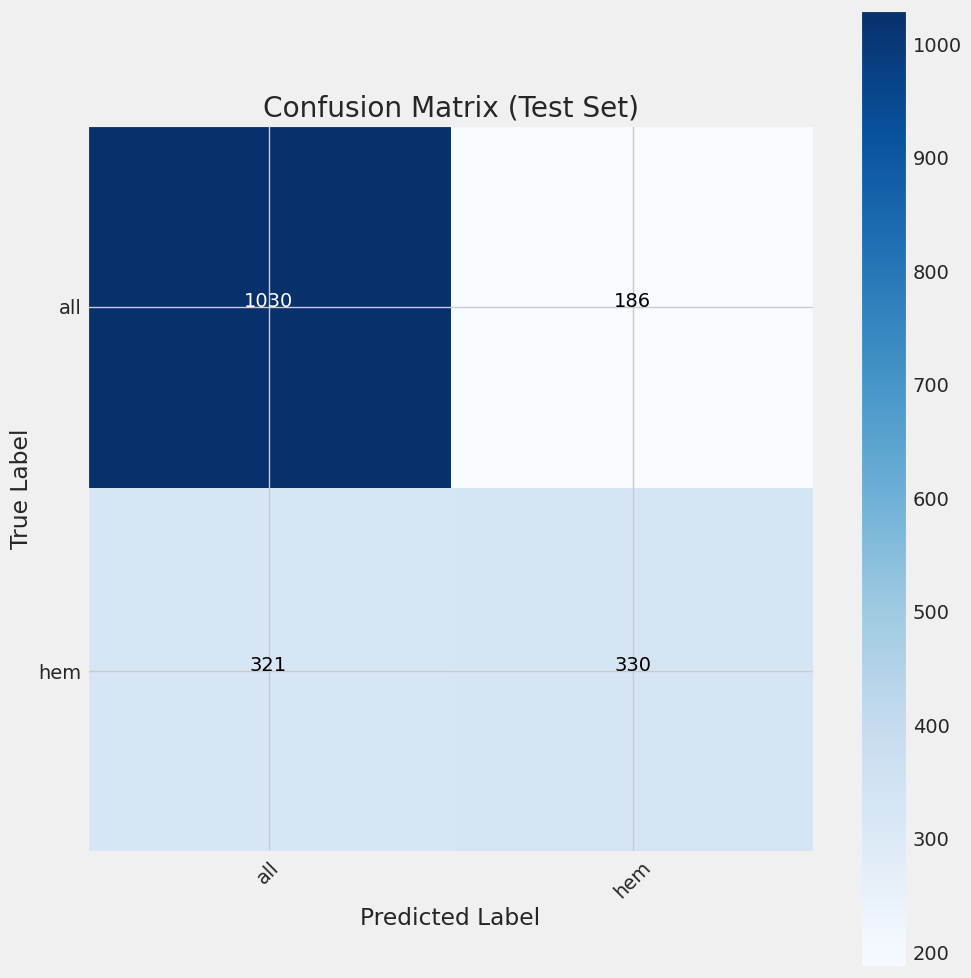

In [16]:
# Initialize values
batch_size = 40
ts_length = len(test_gen.labels)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# Get best model and load its saved weights
best_val_accuracy = np.argmax(val_accuracies)
model.load_weights(f'/content/drive/MyDrive/Models2/ALL-kfold-{model_name_version}-fold{best_val_accuracy + 1}-weights.h5')

# Evaluate against the final test set
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)
  
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
print('')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)  
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix (Test Set)')

# Classification report
print('')
print(classification_report(test_gen.classes, y_pred, target_names= classes))

## **Save model and test prediction data**

In [17]:
# Save model and weights
model.save(f'/content/drive/MyDrive/Models2/ALL-final-{model_name_version}.h5')
print('')
print('Model successfully saved!')
model.save_weights(f'/content/drive/MyDrive/Models2/ALL-final-{model_name_version}-weights.h5')
print('Model weights successfully saved!')

# Save test set predictions
test_pred = np.column_stack((test_gen.filenames,y_pred,test_gen.classes))
test_pred_df = pd.DataFrame(test_pred, columns = ['filenames',f'{model_name_version}_prediction','actual_class'])
print('Test set predictions with actual class labels:')
print(test_pred_df)

test_pred_df.to_csv(f'/content/drive/MyDrive/ClassCSV/ALL-{model_name_version}-test-set-preds.csv', index= False)
print('Successfully saved test set predictions into a CSV file!')


Model successfully saved!
Model weights successfully saved!
Test set predictions with actual class labels:
                                              filenames  \
0     /content/drive/MyDrive/C-NMC_Leukemia/validati...   
1     /content/drive/MyDrive/C-NMC_Leukemia/validati...   
2     /content/drive/MyDrive/C-NMC_Leukemia/validati...   
3     /content/drive/MyDrive/C-NMC_Leukemia/validati...   
4     /content/drive/MyDrive/C-NMC_Leukemia/validati...   
...                                                 ...   
1862  /content/drive/MyDrive/C-NMC_Leukemia/validati...   
1863  /content/drive/MyDrive/C-NMC_Leukemia/validati...   
1864  /content/drive/MyDrive/C-NMC_Leukemia/validati...   
1865  /content/drive/MyDrive/C-NMC_Leukemia/validati...   
1866  /content/drive/MyDrive/C-NMC_Leukemia/validati...   

     InceptionResNetV2_prediction actual_class  
0                               0            0  
1                               0            0  
2                               0   